In [189]:
import os
import cv2
import sknw
import networkx  as nx
import itertools
from sklearn.feature_extraction import image
from extract_patches.core import extract_patches

param_names =         {"a": 0.4,
                       "b": 0.4,
                       "c": 0.405,
                       "alpha": 90,
                       "beta": 90,
                       "gamma": 90,
                       "u":1,
                       "v":1,
                       "w":0,
                       "h":0,
                       "k":0,
                       "l":2,
                       "additional_angle":15}


source_folder = 'data/cufour_simulations/'

In [190]:
def get_volume(a, b, c, alpha, beta, gamma):
    alpha, beta, gamma = np.deg2rad(alpha), np.deg2rad(beta), np.deg2rad(gamma)
    sin_alpha, cos_alpha = np.sin(alpha), np.cos(alpha)
    sin_beta, cos_beta = np.sin(beta), np.cos(beta)
    sin_gamma, cos_gamma = np.sin(gamma), np.cos(gamma)

    volume_ = 1.0 - cos_alpha ** 2.0 - cos_beta ** 2.0 - cos_gamma ** 2.0 + 2.0 * cos_alpha * cos_beta * cos_gamma
    volume = a * b * c * np.sqrt(volume_)

    return volume

def fractional_to_cartesian_M(a, b, c, alpha, beta, gamma, volume):
    alpha, beta, gamma = np.deg2rad(alpha), np.deg2rad(beta), np.deg2rad(gamma)
    sin_alpha, cos_alpha = np.sin(alpha), np.cos(alpha)
    sin_beta, cos_beta = np.sin(beta), np.cos(beta)
    sin_gamma, cos_gamma = np.sin(gamma), np.cos(gamma)

    M = np.zeros((3, 3))
    M[0, 0] = a
    M[0, 1] = b * cos_gamma
    M[1, 1] = b * sin_gamma
    M[0, 2] = c * cos_beta
    M[1, 2] = c * (cos_alpha - cos_beta * cos_gamma) / sin_gamma
    M[2, 2] = volume / (a * b * sin_gamma)

    return M


def convert_coordinates_to_abc_params(params, xyz):

    return convert_coordinates_to_abc(params["a"], params["b"], params["c"], params["alpha"],
                                      params["beta"], params["gamma"],
                                      [params["u"], params["v"], params["w"]],
                                      [params["h"], params["k"], params["l"]],
                                      xyz)


def get_transform_matrix(a, b, c, alpha, beta, gamma, B, g, xyz):

    volume = get_volume(a, b, c, alpha, beta, gamma)

    M = fractional_to_cartesian_M(a, b, c, alpha, beta, gamma, volume)
    M_inv = np.linalg.inv(M)

    a_XYZ, b_XYZ, c_XYZ = np.dot(M, [1, 0, 0]), np.dot(M, [0, 1, 0]), np.dot(M, [0, 0, 1])

    a_star_XYZ = np.cross(b_XYZ, c_XYZ) / volume
    b_star_XYZ = np.cross(c_XYZ, a_XYZ) / volume
    c_star_XYZ = np.cross(a_XYZ, b_XYZ) / volume

    B_XYZ = B[0] * a_XYZ + B[1] * b_XYZ + B[2] * c_XYZ
    g_XYZ = g[0] * a_star_XYZ + g[1] * b_star_XYZ + g[2] * c_star_XYZ

    z_XYZ = B_XYZ / np.linalg.norm(B_XYZ)
    y_XYZ = g_XYZ / np.linalg.norm(g_XYZ)
    x_XYZ = np.cross(y_XYZ, z_XYZ)

    transform_matrix = np.array([x_XYZ, y_XYZ, z_XYZ]).T

    return transform_matrix


def get_a_b_c_vectors(params):

    a, b, c,alpha, beta, gamma, B, g = params["a"], params["b"], params["c"],\
                                   params["alpha"], params["beta"], params["gamma"],\
                                   [params["u"], params["v"], params["w"]],\
                                   [params["h"], params["k"], params["l"]]

    volume = get_volume(a, b, c, alpha, beta, gamma)

    M = fractional_to_cartesian_M(a, b, c, alpha, beta, gamma, volume)

    a_XYZ, b_XYZ, c_XYZ = np.dot(M, [1, 0, 0]), np.dot(M, [0, 1, 0]), np.dot(M, [0, 0, 1])

    a_star_XYZ = np.cross(b_XYZ, c_XYZ) / volume
    b_star_XYZ = np.cross(c_XYZ, a_XYZ) / volume
    c_star_XYZ = np.cross(a_XYZ, b_XYZ) / volume

    B_XYZ = B[0] * a_XYZ + B[1] * b_XYZ + B[2] * c_XYZ
    g_XYZ = g[0] * a_star_XYZ + g[1] * b_star_XYZ + g[2] * c_star_XYZ

    z_XYZ = B_XYZ / np.linalg.norm(B_XYZ)
    y_XYZ = g_XYZ / np.linalg.norm(g_XYZ)
    x_XYZ = np.cross(y_XYZ, z_XYZ)

    transform_matrix = np.array([x_XYZ, y_XYZ, z_XYZ])

    return transform_matrix[0], transform_matrix[1], transform_matrix[2]

def convert_coordinates_to_abc(a, b, c, alpha, beta, gamma, B, g, xyz = None):

    volume = get_volume(a, b, c, alpha, beta, gamma)

    M = fractional_to_cartesian_M(a, b, c, alpha, beta, gamma, volume)
    M_inv = np.linalg.inv(M)

    a_XYZ, b_XYZ, c_XYZ = np.dot(M, [1, 0, 0]), np.dot(M, [0, 1, 0]), np.dot(M, [0, 0, 1])

    a_star_XYZ = np.cross(b_XYZ, c_XYZ) / volume
    b_star_XYZ = np.cross(c_XYZ, a_XYZ) / volume
    c_star_XYZ = np.cross(a_XYZ, b_XYZ) / volume

    B_XYZ = B[0] * a_XYZ + B[1] * b_XYZ + B[2] * c_XYZ
    g_XYZ = g[0] * a_star_XYZ + g[1] * b_star_XYZ + g[2] * c_star_XYZ

    z_XYZ = B_XYZ / np.linalg.norm(B_XYZ)
    y_XYZ = g_XYZ / np.linalg.norm(g_XYZ)
    x_XYZ = np.cross(y_XYZ, z_XYZ)

    transform_matrix = np.array([x_XYZ, y_XYZ, z_XYZ]).T
    inv_transform_matrix = np.linalg.inv(transform_matrix)

    return M_inv, transform_matrix

def rotate_around_x_(vector, angle):

    c, s = np.cos(angle), np.sin(angle)

    return np.dot(vector, np.array([
                [1., 0, 0],
                [0, c, -s],
                [0, s, c]
            ]))


def rotate_around_y_(vector, angle):

    c, s = np.cos(angle), np.sin(angle)

    return np.dot(vector, np.array([
                [c, 0, s],
                [0, 1, 0],
                [-s, 0, c]
            ]))

def rotate_around_z_(vector, angle):

    c, s = np.cos(angle), np.sin(angle)

    return np.dot(vector, np.array([
                [c, -s, 0],
                [s, c, 0],
                [0, 0, 1]
            ]))

In [191]:
config_file = 'delineation/configs/dislocation_segmentation_home.yml'
aug_config_file = 'delineation/configs/aug.yml'
import torch
from skimage.morphology import medial_axis, skeletonize, thin

from delineation.configs.defaults_segmentation import _C as cfg
from delineation.datasets import make_data_loader
from delineation.models import build_segmentation_model
from delineation.utils.settings import evaluate_results
from delineation.utils import settings

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import yaml


PATCH_SIZE = 65
mrSize = 24.0

logdir = '/home/dagnyt/EPFL/dislocations/logdir_results/'
name = 'in_situ_25_deg_skeletonize_aligned'
color = 'red'

cfg.merge_from_file(config_file)
with open(aug_config_file, 'r') as ymlfile:
    cfg_aug = yaml.load(aug_config_file)

_device = settings.initialize_cuda_and_logging(cfg)  # '_device' is GLOBAL VAR

train_loader, val_loader,_ = make_data_loader(cfg, cfg_aug)
seg_model = build_segmentation_model(cfg)

import kornia
hardnet = kornia.feature.HardNet().cuda()
hardnet.eval()

# seg_model.load_state_dict(torch.load('/home/dagnyt/EPFL/dislocations/models/model_2021_01/130_segmentor.tar')['state_dict'])
seg_model.load_state_dict(torch.load('/home/dagnyt/EPFL/dislocations/models_effnet0_features/dislocations_segmentation/with_video_new_04/130_segmentor.tar')['state_dict'])
seg_model.eval()

/home/dagnyt/anaconda3/envs/scem/lib/python3.7/site-packages/ipykernel_launcher.py:34: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Using cuda
EfficientNet-b0
SegmentationModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32

SegmentationModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), strid

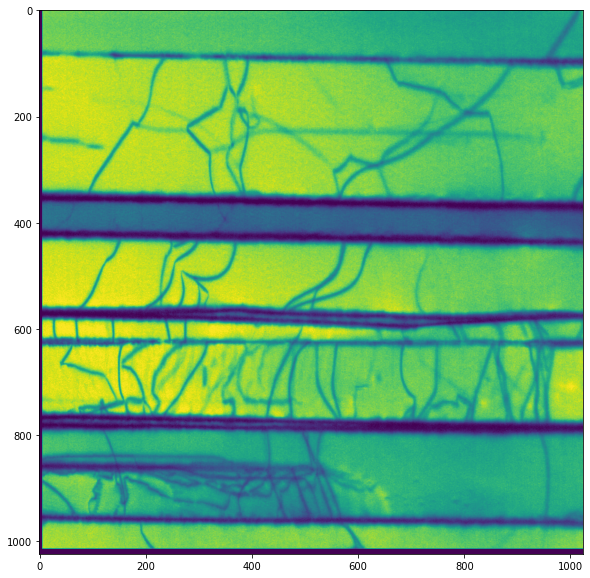

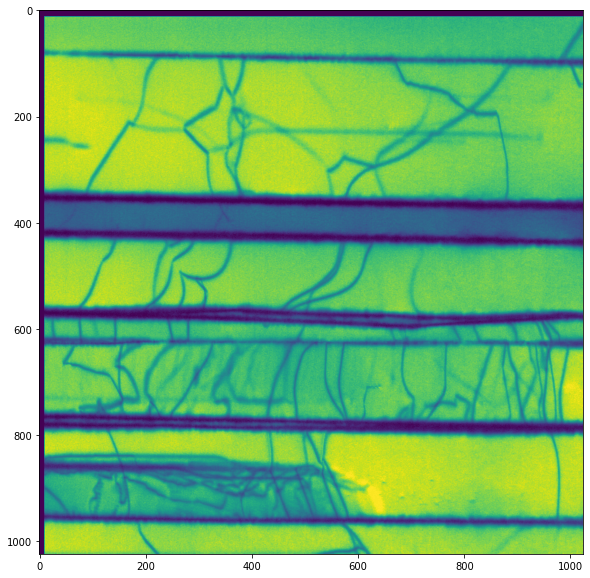

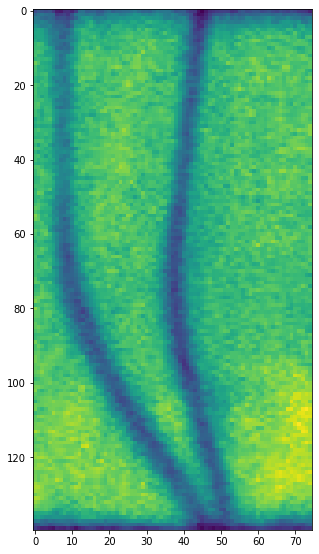

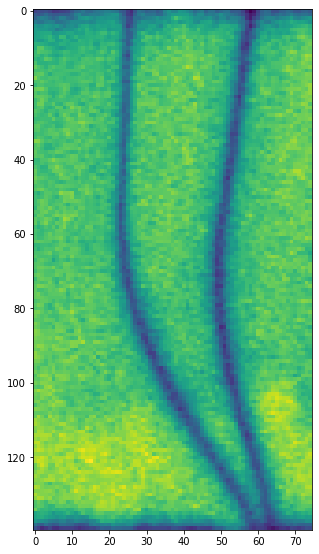

In [192]:
img_left_path, img_right_path = os.path.join(source_folder,'5013.jpg'), os.path.join(source_folder,'5015.jpg')
img_left, img_right = cv2.imread(img_left_path, 0), cv2.imread(img_right_path, 0)

plt.figure(figsize=(10,10))
plt.imshow(img_left)

plt.figure(figsize=(10,10))
plt.imshow(img_right)

with torch.no_grad():
    torch.cuda.empty_cache()

    _, seg_res1 = seg_model(torch.from_numpy(img_left/255.0).unsqueeze(0).unsqueeze(0).cuda().float())
    _, seg_res2 = seg_model(torch.from_numpy(img_right/255.0).unsqueeze(0).unsqueeze(0).cuda().float())
seg_map1 = seg_res1[0].squeeze().data.cpu().numpy()>0.05
seg_map2 = seg_res2[0].squeeze().data.cpu().numpy()>0.05

skeleton = skeletonize(seg_map1).astype(np.uint8)

img_left, img_right = img_left[630:770, 515:590], img_right[630:770, 515:590]
seg_map1, seg_map2 = seg_map1[630:770, 515:590], seg_map2[630:770, 515:590]

plt.figure(figsize=(5,10))
plt.imshow(img_left)

plt.figure(figsize=(5,10))
plt.imshow(img_right)

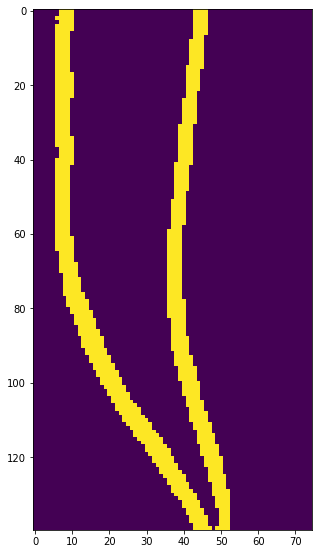

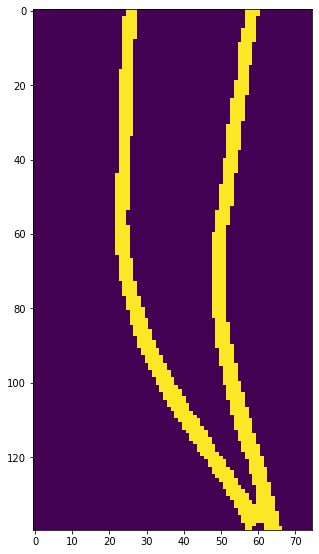

In [193]:
plt.figure(figsize=(5,10))
plt.imshow(seg_map1)

plt.figure(figsize=(5,10))
plt.imshow(seg_map2)

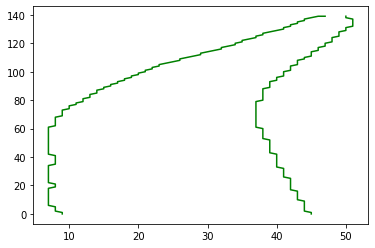

In [194]:
skeleton = skeletonize(seg_map1).astype(np.uint8)
    # draw image
graph_ = sknw.build_sknw(skeleton)
# plt.imshow(seg_map1)

dislocations = []

subgraphs = list(nx.connected_component_subgraphs(graph_))
for graph in subgraphs:
            for (s, e) in graph.edges():
                ps = graph[e][s]['pts']
                if len(ps) > 10:
                    dislocations.append(ps)
                    plt.plot(ps[:, 1], ps[:, 0], 'green')
kpts1 = np.where(seg_map1 == 1)
kpts1 = np.array([[kpts1[0][idx], kpts1[1][idx]] for idx in range(len(kpts1[0]))])
kpts2 = np.where(seg_map2 == 1)
kpts2 = np.array([[kpts2[0][idx], kpts2[1][idx]] for idx in range(len(kpts2[0]))])

kpCheck = [cv2.KeyPoint(0.0, 0.0, 1), cv2.KeyPoint(0.0, 0.0, 1), cv2.KeyPoint(100.0, 0.0, 1), cv2.KeyPoint(0.0, 100.0, 1)]

show_idx = 0

kpL = [cv2.KeyPoint(float(kp[1]), float(kp[0]), 1) for kp in kpts1]
kpR = [cv2.KeyPoint(float(kp[1]), float(kp[0]), 1) for kp in kpts2]


patches1 = extract_patches(kpL, img_left, PATCH_SIZE, mrSize, 'cv2')
patches2 = extract_patches(kpR, img_right, PATCH_SIZE, mrSize, 'cv2')

torch.cuda.empty_cache()
import torch
bs = 1024
desL, desR = [], []

with torch.no_grad():
        patches1 = np.array([cv2.resize(patch,(32,32)) / 255. for patch in patches1])
        patches1 -= 0.443728476019
        patches1 /= 0.20197947209

        for i in range(0, len(patches1), bs):
            data_a = patches1[i: i + bs, :, :].astype(np.float32)
            desc1 = hardnet(torch.from_numpy(data_a).cuda().unsqueeze(1).float())
            desL.extend(desc1.data.cpu().numpy().squeeze())

with torch.no_grad():
        patches2 = np.array([cv2.resize(patch,(32,32)) / 255. for patch in patches2])
        patches2 -= 0.443728476019
        patches2 /= 0.20197947209

        for i in range(0, len(patches2), bs):
            data_a = patches2[i: i + bs, :, :].astype(np.float32)
            desc2 = hardnet(torch.from_numpy(data_a).cuda().unsqueeze(1).float())
            desR.extend(desc2.data.cpu().numpy().squeeze())

desL, desR = np.array(desL), np.array(desR)

kpts1_same_y = {}
kpts2_same_y = {}

for idx, kpt in enumerate(kpL):
        if kpt.pt[1] in kpts1_same_y:
            kpts1_same_y[kpt.pt[1]].append((kpt, desL[idx], idx))
        else:
            kpts1_same_y[kpt.pt[1]] = [(kpt, desL[idx], idx)]

for idx, kpt in enumerate(kpR):
        if kpt.pt[1] in kpts2_same_y:
            kpts2_same_y[kpt.pt[1]].append((kpt, desR[idx], idx))
        else:
            kpts2_same_y[kpt.pt[1]] = [(kpt, desR[idx], idx)]

keys = kpts1_same_y.keys()

from scipy.optimize import linear_sum_assignment
from scipy import spatial

matches, matches_r = [], []

for key in keys:
        try:
            im1_kp = kpts1_same_y[key]
            im2_kp = kpts2_same_y[key]

            descs1 = np.array([x[1] for x in im1_kp])
            descs2 = np.array([x[1] for x in im2_kp])

            indx1 = np.array([x[2] for x in im1_kp])
            indx2 = np.array([x[2] for x in im2_kp])

            cost = spatial.distance.cdist(descs1, descs2, metric='euclidean')

            row_ind, col_ind = linear_sum_assignment(cost)

            indx1, indx2 = indx1[row_ind], indx2[col_ind]

            matches.extend([cv2.DMatch(indx1[i], indx2[i], 0) for i in range(len(indx1))])

        except Exception as ex:
            print(ex)
       # break

good, good_r = matches, matches_r

MIN_MATCH_COUNT = 8
import pydegensac

if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kpL[m.queryIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
        dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
        F, mask = pydegensac.findHomography(src_pts, dst_pts, 15.0)

        matchesMask = mask.ravel().tolist()

differences = dst_pts[mask.squeeze()] - src_pts[mask.squeeze()]
differences = differences.squeeze()
src_pts, dst_pts = src_pts[mask.squeeze()], dst_pts[mask.squeeze()]
    
dislocation_kp_set = {}

for indx_, kpt in enumerate(src_pts):
        dislocation_kp_set[str([kpt[0], kpt[1]])] = differences[indx_]

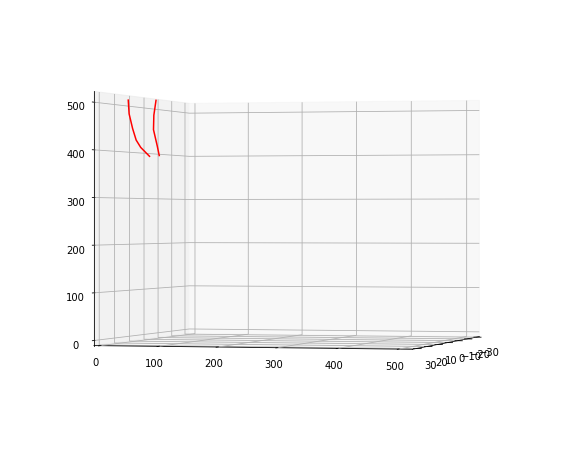

In [237]:
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate

def filtering(xx, yy, dd):
    
        mean = np.mean(dd, axis=0)
        sd = np.std(dd, axis=0)
        filtered_indices = [indx_x for indx_x,d in enumerate(dd) if d > mean -  2 * sd]

        xx, yy, dd = xx[filtered_indices], yy[filtered_indices], dd[filtered_indices]
        
        dd_diff= np.diff(dd)
        filtered_indices = np.where(abs(dd_diff)<10)
        xx, yy, dd = xx[filtered_indices], yy[filtered_indices], dd[filtered_indices]

        xx = scipy.signal.medfilt(xx, 5)
        yy = scipy.signal.medfilt(yy, 5)
        dd = scipy.signal.medfilt(dd, 7)
        
        xx_unique, unique_indices = np.unique(xx, return_index=True)
        if len(xx_unique)>4:
            tck, u = interpolate.splprep([xx[unique_indices], yy[unique_indices], dd[unique_indices]], s = 2)
            xx, yy, dd = interpolate.splev(tck[0], tck)

        return xx, yy, dd

fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111, projection='3d')

rotation_angle = 15

ax.set_ylim3d(0, 512)
ax.set_zlim3d(0, 512)
ax.set_xlim3d(-32, 32)


xx_all, yy_all, zz_all = [], [], []

for i, disl in enumerate(dislocations):
                
        dl = np.zeros(img_left.shape)
        seg_masked = np.zeros(img_left.shape)

        xx, yy, dd = [], [], []
        D = 32
        for idx, kp in enumerate(dislocations[i].squeeze()):
                kpt = str([float(kp[1]),float(kp[0])])
                if (kpt in dislocation_kp_set.keys()):
                    dl = dislocation_kp_set[kpt]              
                    xx.append(int(kp[0]))
                    yy.append(int(kp[1]))
                    dd.append(dl[0])
                    
        xx, yy, dd = np.array(xx), np.array(yy), np.array(dd)

        xx, yy, dd = filtering(xx, yy, dd)
        
        xx,yy,dd = xx[1::15], yy[1::15], dd[1::15]

        xx_all.append(xx)
        yy_all.append(yy)
        zz_all.append(dd)
        ax.view_init(0, rotation_angle)

        ax.plot(dd, yy, 512-xx, c=color)


In [238]:
print(xx_all, yy_all, zz_all)

[array([  2.00095975,  31.00590996,  62.0731164 ,  86.96145084,
       102.93021482, 121.96403452]), array([  0.99193138,  33.06974926,  63.9949536 ,  99.00214435,
       119.92007154])] [array([ 8.00235982,  6.99611176,  7.81163152, 14.0930659 , 22.16916494,
       35.10028211]), array([43.98052071, 40.1660042 , 36.9916813 , 40.92305638, 47.18908429])] [array([17.99994856, 17.03812099, 14.98802412, 15.00000001, 15.00068859,
       13.9999946 ]), array([12.99999991, 13.00238542, 11.99999832, 10.93088635, 12.00503791])]


In [239]:
re_arranged_dislocations = [] 
for i in range(0, len(xx_all)):
    dislocation = []
    for j in range(len(xx_all[i])):
        dislocation.append([xx_all[i][j], yy_all[i][j], zz_all[i][j]])
    dislocation = np.array(dislocation)
    re_arranged_dislocations.append(dislocation)
re_arranged_dislocations = np.array(re_arranged_dislocations)

a,b,c = 0.4, 0.4, 0.405
alpha, beta, gamma = 90, 90, 90
B = np.array([1,1,0])
g = np.array([0,0,2])

M_inv, transform_matrix  = convert_coordinates_to_abc(a,b,c,alpha,beta,gamma, B,g)

dislocations_in_abc = []
for dislocation in re_arranged_dislocations:
    xyz_abc = np.dot(M_inv, np.dot(transform_matrix, dislocation.T))
    xyz_abc_rotated = rotate_around_z_(dislocation, 15)
    dislocations_in_abc.append(xyz_abc_rotated)

dislocations_in_abc = np.array(dislocations_in_abc)

In [240]:
dislocations_in_abc[0]

array([[   3.68373235,   -7.38049582,   17.99994856],
       [ -19.00532862,  -25.47762776,   17.03812099],
       [ -42.07638725,  -46.29979484,   14.98802412],
       [ -56.8990137 ,  -67.25630587,   15.00000001],
       [ -63.77850168,  -83.77591372,   15.00068859],
       [ -69.82931619, -105.97698864,   13.9999946 ]])

In [241]:
dislocations_line_directions = []
for  dislocation in dislocations_in_abc:
    line_directions = []
    for i in range(1, len(dislocation)):
        line_directions.append(dislocation[i] - dislocation[i-i])
    append = np.array(line_directions)
    dislocations_line_directions.append(line_directions)
    
dislocations_line_directions = np.array(dislocations_line_directions)
print('Dislocation 1: ')
print(dislocations_line_directions[0])
print('Dislocation 2: ')
print(dislocations_line_directions[1])

Dislocation 1: 
[array([-22.68906097, -18.09713194,  -0.96182757]), array([-45.7601196 , -38.91929902,  -3.01192444]), array([-60.58274605, -59.87581005,  -2.99994855]), array([-67.46223403, -76.3954179 ,  -2.99925997]), array([-73.51304854, -98.59649282,  -3.99995396])]
Dislocation 2: 
[array([-2.68496642e+01, -1.79619728e+01,  2.38550108e-03]), array([-52.40739174, -35.66076242,  -1.00000159]), array([-76.445406  , -61.41213102,  -2.06911356]), array([-88.2617807 , -79.77503037,  -0.994962  ])]
